In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Imports

In [2]:
### Imports ###

## Utility Libraries ##
import time
import re
from imblearn.over_sampling import SMOTE

## Plotting library ##
import matplotlib.pyplot as plt

## SKLearn Imports ##

# Pre-processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.linear_model import SGDClassifier

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
 


* 3 Models are selected from sklearn library 
1. Logistic Regression - Model 1
2. Naive Bayes (in general) and BernoulliNB (in particular) - Model 2
3. SGD Classifier for SVC - Model 3

In [3]:
### Loading the dataset ###

data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')

# ****Data Preprocessing****

In [4]:
np.random.seed(37) # To make notebook stable across runs

print(data.shape)
data.head()

(162758, 5)


,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


* The data has 5 columns with the column 'sentiment' as the target variable.
* And, the column 'reviewerName' will be used as feature variable.
* Moreover, columns 'movieid' and 'reviewerName' don't play a key role in sentiment analysis

In [5]:
#movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

In [6]:
# # Merging training and movies datasets
# data_movies_merged = pd.merge(data, movies, on='movieid',how='inner')
# data_movies_merged.head()

* Movies dataset was loaded and examined but not used in this project

In [7]:
# Examining the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


* There are 162,758 rows in dataset.
* All columns ( 5 in total ), are text (object), except 'isFrequentReviewer', which is Boolean.

In [8]:
# Checking for missing values

data.isnull().sum() # Column 'reviewText' has 6447 null values

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [9]:
data = data.fillna('') # Filling the missing values with an empty string

Filling missing values with an empty string seemed to be best choice in this analysis.

In [10]:
# Splitting dataset into feature matrix X_text and label vector y
X_text = np.array(data["reviewText"])
y = np.array(data["sentiment"])

print("Shape of label vector:", y.shape)
print("Shape of feature vector:", X_text.shape) # Feature matrix is vector, as it is not transformed yet

Shape of label vector: (162758,)
Shape of feature vector: (162758,)


In [11]:
print(type(X_text)) # Self Reference
print(type(y)) # Self Reference

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Both feature matrix and label vector, are of class numpy.ndarray.

In [12]:
print("\nDiscrete value counts in targer vector\n")
data["sentiment"].value_counts()


Discrete value counts in targer vector



POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64

**It is clearly visible that Positive class outnumbers the Negative class.**

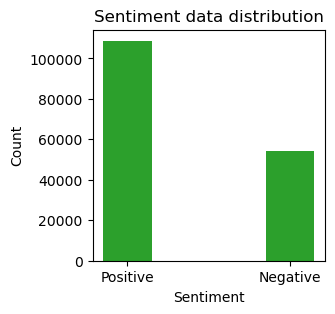

In [13]:
### Plotting the class counts as a Bar graph

plt.figure(figsize=(3,3))
plt.bar(['Positive', 'Negative'], [108761, 53997], color=['tab:green'], width=0.3)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment data distribution")
plt.show()

In [14]:
## Distribution of Frequent Reviewers ##

print(data["isFrequentReviewer"].value_counts())
print("\nNumber of frequent reviewrs:", data["isFrequentReviewer"].value_counts()[1])

False    113189
True      49569
Name: isFrequentReviewer, dtype: int64

Number of frequent reviewrs: 49569


**There are 49,569 frequent reviewers.**

In [15]:
# ### Adding 'isFrequentReviewer' as extra feature ###

# freq = np.array(data["isFrequentReviewer"])

# # #Label encoding vector freq ( isFrequentReviewer )
# # enc = LabelEncoder()

# # freq = enc.fit_transform(freq)
# freq.reshape(-1, 1)
# freq = np.squeeze(freq)

# print("Label vector:", freq) #New freq Vector


**The column 'isFrequentReviewer', is logical to be added to the feature matrix, but was not added due to difficulty in pre-processing.**

In [16]:
# ### Joining the 'freq' vector to the X_vectorized feature matrix ###

# X_text = np.concatenate((X_text.reshape(-1,1), freq.reshape(-1,1)), axis=1)

**Text Processing**

In [17]:
### Text Processing ###


X = [] 
X = [x.lower() for x in X_text]  # Converting the whole corpus into lowercase


pattern = r'[0-9]' # Initialising variable 'pattern' with a pattern that captures a number
X_without_digits = [re.sub(pattern, '', x) for x in X] # Substituting all the numbers with an empty string

print("First review sentence:\n\n" + X[1] + "\n")
print("First review sentence without numbers:\n\n" + X_without_digits[1] + "\n")    

## Converting text to numerical attributes ##

# Using Tf-idf Vectorizer to convert each sentence into numerical features
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
X_vectorized = vectorizer.fit_transform(X_without_digits) #New training feature matrix

print("Shape of Vectorized feature matrix:", X_vectorized[0].shape, "\n")
print("First review sentence vectorized:\n", X_vectorized[0], "\n")

#Label encoding vector y
enc = LabelEncoder()

y_int = enc.fit_transform(y)
print("Label vector:", y_int) #New Label Vector 
#Positive: 1, Negative: 0

First review sentence:

with a cast that reads like the vogue oscar party guest list, valentine's day should have been can't-miss cinema instead of standard hollywood schmaltz.

First review sentence without numbers:

with a cast that reads like the vogue oscar party guest list, valentine's day should have been can't-miss cinema instead of standard hollywood schmaltz.

Shape of Vectorized feature matrix: (1, 1179785) 

First review sentence vectorized:
   (0, 674060)	0.29614253294221665
  (0, 987667)	0.2279534969969309
  (0, 374081)	0.31381733124511263
  (0, 202001)	0.31381733124511263
  (0, 878972)	0.31381733124511263
  (0, 679288)	0.1475270007099114
  (0, 883512)	0.17554089322781144
  (0, 914757)	0.2858034387272126
  (0, 475856)	0.29614253294221665
  (0, 637708)	0.16910753471649662
  (0, 673994)	0.181259067888113
  (0, 987514)	0.17542856113486752
  (0, 374045)	0.2258449125001981
  (0, 201998)	0.255102922191255
  (0, 675710)	0.08249320667819579
  (0, 876885)	0.10860933087109752
  (0, 

* Text processing steps used: 
1. Convertng the corpus (all reviews) into lowercase.
2. Removing all the digits, using regular expressions library.
3. Converting the corpus into a document-term matrix (into numerical features) using Tf-idf vectorizer.
4. Tokens of 1 and 2 words are being captured using parameter 'ngram_range'.
5. Using 'max_features' parameter to limit the number of features being taken into account. # Skipped step --- Using all features
6. Transforming the label vector using LabelEncoder, as it contains categorical features (POSITIVE, NEGATIVE).
7. POSITIVE replaced by 1, and NEGATIVE by 0.

In [18]:
print(X_vectorized.shape) # Self Reference
print(y_int.shape) # Self Reference

(162758, 1179785)
(162758,)


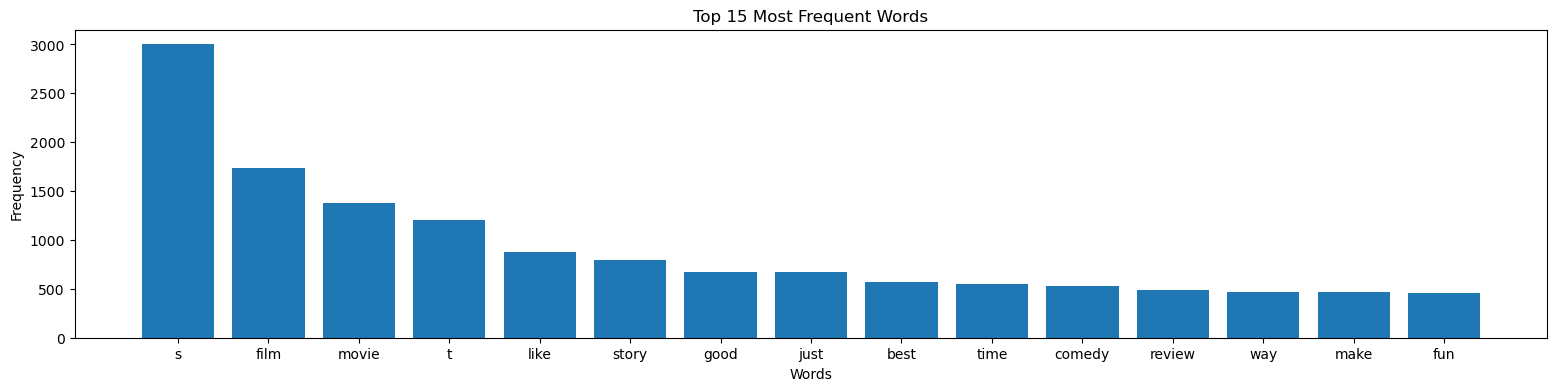

In [19]:
# Getting the feature names (Words)
words = vectorizer.get_feature_names_out()

# Calculating word frequencies by summing along all rows
word_freq = X_vectorized.sum(axis=0).A1

# Sorting words based on their frequencies
sorted_indices = word_freq.argsort()[::-1]
sorted_words = [words[index] for index in sorted_indices]
sorted_freq = word_freq[sorted_indices]

# Plotting the top 10 most frequent words
plt.figure(figsize=(19, 4))
plt.bar(sorted_words[:15], sorted_freq[:15])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Frequent Words')
plt.show()

* Since there is a class imbalance, there are more positive words which show up in the above chart like 'like', 'good words', 'best' and so on.

**SMOTE**

In [20]:
### Taking care of Class Imbalance using SMOTE ###
# (as there is 33-67 class imbalance)

start = time.time()

oversampler = SMOTE()
X_vectorized, y_int = oversampler.fit_resample(X_vectorized, y_int)

end = time.time()

print("Time elapsed: %0.2f" % (end-start) + " s") # Self Reference

Time elapsed: 809.08 s


* SMOTE - Synthetic Minority Oversampling TEchnique
* SMOTE is used for oversamplig the minority class (Negative) as there is 33-67 class imbalance in the dataset.

In [21]:
print("Shape of oversampled feature matrix:", X_vectorized.shape)
print("Shape of oversampled label vector:", y_int.shape)

Shape of oversampled feature matrix: (217522, 1179785)
Shape of oversampled label vector: (217522,)


**Train-Test-Split**

In [22]:
### Splitting the dataset into training and test sets ###

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_int, test_size=0.2, random_state=37)
print(X_train.shape)
print(y_train.shape)

(174017, 1179785)
(174017,)


In [23]:
print("Shape of final training feature matrix:", X_train.shape)
print("Shape of final training label vector:", y_train.shape)

Shape of final training feature matrix: (174017, 1179785)
Shape of final training label vector: (174017,)


**Shape of final training feature matrix: (174017, 1179785)
Shape of final training label vector: (174017,)**

In [24]:
### Feature Scaling ###

**Feature scaling is skipped as Tf-idf Vectorizer has an advantage over**
**Count Vectorizer as it already takes into account term frequency and inverse document frequency,**
**therefore, resulting into float values.**

In [25]:
# #Dimensionality Reduction......
# from sklearn.decomposition import TruncatedSVD
# start = time.time()
# tsvd = TruncatedSVD(n_components=100)
# X_dim_red = tsvd.fit_transform(X)
# end = time.time()
# print("Time elapsed: %0.2f" % (end-start)+"s")

TruncatedSVD was used for dimensionality reduction but, after testing the performance of 3 models on full feature set, the whole matrix is being used.

In [26]:
# #Taking care of Class Imbalance using class weights distribution
# #(as outlook of train.csv shows that there is 33-67 class imbalance)

# count_class_positive = pd.Series(y_train).value_counts()[1]
# count_class_negative = pd.Series(y_train).value_counts()[0]
# ratio = count_class_positive/count_class_negative
# print(ratio)

* class_weight in built parameters of models are more useful.

In [27]:
#Data Preprocessing ends......

In [28]:
f1_score_list = [] # Initialising an empty list for storing f1_score values
time_taken = [] # Initialising an empty list for storing time taken by models to fit

# Support Vector Classifier

In [29]:
# Model 3 : Support Vector Classifier


start = time.time()

# model = SGDClassifier(alpha=0.013,
#                       eta0=0.001,
#                       learning_rate='adaptive',
#                       max_iter=100,
#                       random_state=37) # Parameters found from GridSearchCV

model = SGDClassifier(random_state=37) # Default parameters are being used
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

end = time.time()

print("Time elapsed: %0.2f" % (end-start)+" s")
time_taken.append(end-start)

              precision    recall  f1-score   support

           0    0.69860   0.87285   0.77607     21605
           1    0.83363   0.62849   0.71667     21900

    accuracy                        0.74984     43505
   macro avg    0.76611   0.75067   0.74637     43505
weighted avg    0.76657   0.74984   0.74617     43505

Time elapsed: 1.11 s


SGDClassifier's default parameter are better than parameters found from grid search.

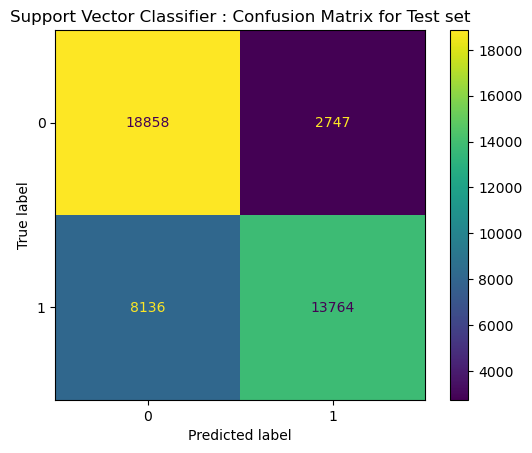

In [30]:
### Confusion Matrix ###

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Support Vector Classifier : Confusion Matrix for Test set')
plt.show()

* False Negatives > False Positives

In [31]:
# ### Grid Search for SGD Classifier ###

# param_grid = {
#                'alpha': [0.011, 0.013, 0.015],
#                'max_iter': [100, 500],
#                'eta0' : [1e-4, 1e-2, 1e-3],
#                'learning_rate' : ['adaptive']#, 'invscaling', 'optimal', 'constant']
# }

# start = time.time()

# grid_search = GridSearchCV(model, param_grid, n_jobs=-1, error_score='raise', scoring='f1', cv=3)
# grid_search.fit(X_train, y_train)

# end = time.time()

# print("Time elapsed: %0.5f" % (end-start) + " s")

# grid_search.best_estimator_

In [32]:
# ### Cross validating performance of best estimator ###

# scores = cross_val_score(model, X_train, y_train, cv=5)
# print("Mean accuracy of best model on training data: %0.3f" % scores.mean())

In [33]:
print("F1 score of Support Vector Classifier on test data is: %0.3f" % f1_score(y_test, y_pred, average="micro"))
f1_score_list.append(f1_score(y_test, y_pred, average="micro"))

F1 score of Support Vector Classifier on test data is: 0.750


**F1 score of Support Vector Classifier on test data is 0.751**

# Naive Bayes Classifier

In [34]:
# Model 2 : Bernoulli Naive Bayes Classifier

start = time.time()

#model = MultinomialNB(alpha=1.4, force_alpha=True) --- # Skipped
#model = ComplementNB(alpha=1.35, fit_prior=False, force_alpha=True) --- # Skipped

model = BernoulliNB(alpha=0.12, fit_prior=False, force_alpha=True) # Parameters learned from GridSearchCV

# Parameter fir_prior is set to False because class imbalance is handled by SMOTE

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

end = time.time()

print("Time elapsed: %0.2f" % (end-start)+"s")
time_taken.append(end-start)

              precision    recall  f1-score   support

           0    0.79724   0.92418   0.85603     21605
           1    0.91127   0.76813   0.83360     21900

    accuracy                        0.84563     43505
   macro avg    0.85426   0.84616   0.84482     43505
weighted avg    0.85464   0.84563   0.84474     43505

Time elapsed: 0.37s


In [35]:
# ### Grid Search for Naive Bayes ###
    
# param_grid = {
#                #'alpha': [0.11, 0.09, 0.07, 0.1, 0.13, 0.19]  # C
#                'alpha': [0.11, 0.09, 0.12, 0.1, 0.13, 10, 0.001], # B
#                'force_alpha': [True, False],
#                'fit_prior': [True, False]
# }

# start = time.time()

# grid_search2 = GridSearchCV(model, param_grid, n_jobs=-1, error_score=0, scoring='f1', cv=5)
# grid_search2.fit(X_train, y_train)

# end = time.time()

# print("Time elapsed: %0.5f" % (end-start) + " s")

# grid_search2.best_estimator_

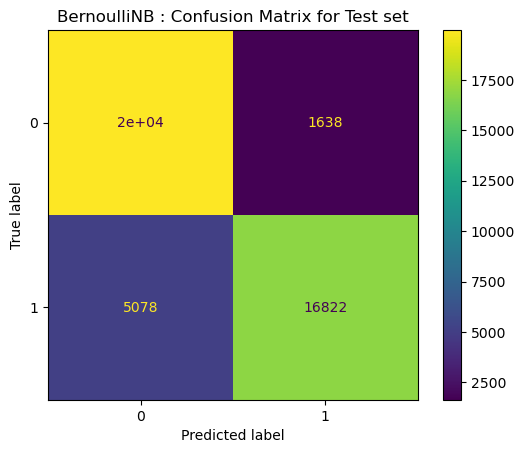

In [36]:
# ### Confusion Matrix ###

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('BernoulliNB : Confusion Matrix for Test set')
plt.show()

* False Negatives > False Positives

In [37]:
# ### Cross validating performance of best estimator ###

# scores = cross_val_score(model, X_train, y_train, cv=5)
# print("Mean accuracy of best model on training data: %0.3f" % scores.mean())

In [38]:
print("F1 score of Bernoulli Naive Bayes on test data is: %0.3f" % f1_score(y_test, y_pred, average="micro"))
f1_score_list.append(f1_score(y_test, y_pred, average="micro"))

F1 score of Bernoulli Naive Bayes on test data is: 0.846


**F1 score of Bernoulli Naive Bayes on test data is 0.847**

# Logistic Regression

In [39]:
# Model 1 : LOGISTIC REGRESSION


start = time.time()

model = LogisticRegression(max_iter=1000, C=60, random_state=37) # Parameters found from GridSearchCV
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

end = time.time()

print("Time elapsed: %0.2f" % (end-start)+" s")
time_taken.append(end-start)

              precision    recall  f1-score   support

           0    0.83265   0.92483   0.87632     21605
           1    0.91675   0.81662   0.86379     21900

    accuracy                        0.87036     43505
   macro avg    0.87470   0.87073   0.87006     43505
weighted avg    0.87498   0.87036   0.87002     43505

Time elapsed: 240.76 s


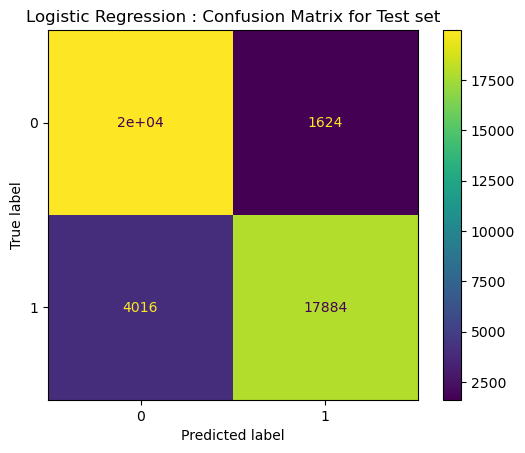

In [40]:
### Confusion Matrix ###

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Logistic Regression : Confusion Matrix for Test set')
plt.show()

* False Negatives > False Positives

In [41]:
# ### Grid Search for Logistic Regression ###

# param_grid = {
#                'solver': ["lbfgs"],
#                'penalty': ['l2'], # solver 'lbfgs' does not support L1 regulatization
#                'C': [55, 60, 65]
# }

# start = time.time()

# grid_search = GridSearchCV(model, param_grid, n_jobs=-1, error_score='raise', scoring='f1')
# grid_search.fit(X_train, y_train)

# end = time.time()

# print("Time elapsed: %0.5f" % (end-start) + " s")

# grid_search.best_params_

In [42]:
# ### Cross validating performance of best estimator ###

# scores = cross_val_score(model, X_train, y_train, cv=5)
# print("Mean accuracy of best model on training data: %0.3f" % scores.mean())

In [43]:
print("F1 score of Logistic Regression on test data is: %0.3f" % f1_score(y_test, y_pred, average="micro"))
f1_score_list.append(f1_score(y_test, y_pred, average="micro"))

F1 score of Logistic Regression on test data is: 0.870


**F1 score of Logistic Regression on test data is 0.872**

**Comparing model performance**

[0.7498448454200667, 0.8456269394322492, 0.8703597287668084]


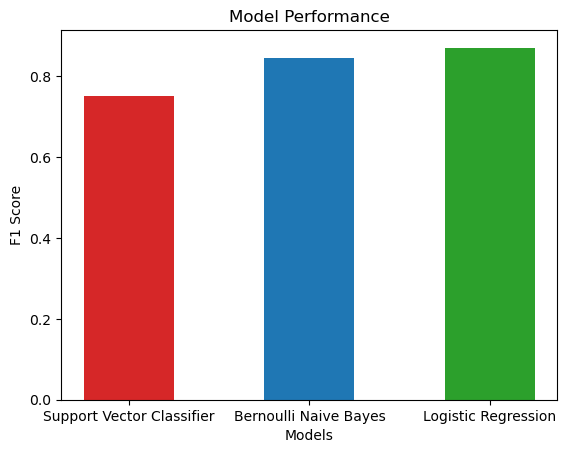

In [44]:
## Plotting the f1-scores of all 3 models ##

models = ['Support Vector Classifier', 'Bernoulli Naive Bayes', 'Logistic Regression']

print(f1_score_list) # F1 Score list

plt.figure()
plt.bar(models, f1_score_list, width=0.5, color=['tab:red', 'tab:blue', 'tab:green'])
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("Model Performance")
plt.show()

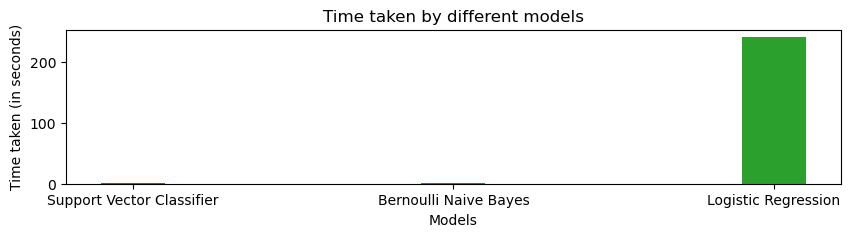

In [45]:
## Plotting the time taken by all 3 models to fit the dataset ##

plt.figure(figsize=(10,2))
plt.bar(models, time_taken, width=0.2, color=['tab:red', 'tab:blue', 'tab:green'])
plt.xlabel("Models")
plt.ylabel("Time taken (in seconds)")
plt.title("Time taken by different models")
plt.show()

**Model Insights**
* Logistic Regression gives the best results among all the models.
* BernoulliNB is the fastest among all.
* Among all models, the number of False Negatives are always high.
* There is some evidence of overfitting as the test score is lower than the train score.

# Test Set

In [46]:
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
#test.head()

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


test dataset has 4 columns, with the column 'isTopCritic' as the boolean variable, rest are text.

In [48]:
test.isnull().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

There are 2510 missing values in the test dataset.

In [49]:
test = test.fillna('')

Replacing the missing values with an empty string. (Same practice as the train dataset)

In [50]:

#vectorizing test reviews
Test = np.array(test["reviewText"])
# print(test_fm[0])
T = []
T = [x.lower() for x in Test] # Changing the corpus into lowercase

T_new = [re.sub(pattern, '', x) for x in T] # Replacing all the digits with an empty string

T_new_vec = vectorizer.transform(T_new) # Transforming the test 'reviewText' column with vocabulary learnt from train set

Following the text processing steps as the training set.

In [51]:
### Predicting using the best of the 3 models ###
prediction = model.predict(T_new_vec)

#Transforming labels to their original form...

output = []
for x in prediction:
    if x == 1:
        output.append("POSITIVE")
    else:
        output.append("NEGATIVE")
print(output[:5])
print(prediction[:5])

['POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE']
[1 1 1 1 1]


In [52]:
submission = pd.DataFrame(columns = ['id','sentiment'])
submission['id'] = [i for i in range(len(output))]
submission['sentiment'] = output

Creating a pandas dataframe consisting 2 columns, 'id' and 'sentiment' which is the target variable.

Creating the 

In [53]:
submission.shape

(55315, 2)

In [54]:
print(submission[0:10])

   id sentiment
0   0  POSITIVE
1   1  POSITIVE
2   2  POSITIVE
3   3  POSITIVE
4   4  POSITIVE
5   5  POSITIVE
6   6  POSITIVE
7   7  NEGATIVE
8   8  POSITIVE
9   9  POSITIVE


In [55]:
submission.to_csv('submission.csv', index = False)

**Submitting the dataframe 'submission' as a csv file for final submission.**